In [1]:
import requests
from IPython.core.display import HTML
# HTML(f"""
# <style>
# @import "https://cdn.jsdelivr.net/npm/bulma@0.9.4/css/bulma.min.css";
# </style>
# """)

# Data Preprocessing

**Overview**
This exercise is about finding the pupil centers (features) in images of eyes and is a prerequisite for the first mandatory assignment. You will furthermore use the data in subsequent exercises.
The data collection session provided a trial folder for each run for each test subject, containing eye images for each calibration pattern. 
This notebook contains necessary functions to visualize and preprocess the images collected while the test subjects were given four different tasks gazing at _grid_, _ellipse_, _line_ and _random_ pattern.

The following steps are about visualization and preprocessing your eye tracking data collected for the assignement. Preprocessing is an important factor for the performance of the model. 
This exercise is about:
- Visualization of the data.
- Preprocessing.    - Frame extraction.
    - Pupil center detection.
    - Determine mean pupil center for each gaze coordinate on the screen.



The following tasks introduce you to the data set of `test_subject_0`
. This dataset has been preprocessed and should give you some hints of how you can preprocess your data for the assignment.

---
**Task 1 (easy): Download data**
1. Download the folder `test_subject_0`
 from the folder `Data`
 on OneDrive. Paste the folder in the `sessions`
 folder for exercises week 2.


---## Visualization
Get familiar with the data by visualising it. 
The data set of `test_person_0`
 contains  four subsets $\mathcal{D}_{p0}, \mathcal{D}_{p1}, \mathcal{D}_{p2}, \mathcal{D}_{p3}$ each containing a recording session using a web camera. 

**Details about the data format**
Each dataset, $\mathcal{D}_i$, contains a dictionary of training and test data.
**Dataset elements:**
- `pupils_n_train`
: Normalized pupil positions for the 9 calibration images (an $9 \times 2$ array containing the x and y coordinates (`px`
, `py`
)).
- `pupils_n_test`
: Normalized pupil positions for the test images (an $N \times 2$ array containing the x and y coordinates (`px`
, `py`
)).
- `pupils_train`
: Pupil positions for the 9 calibration images (an $9 \times 2$ array containing the x and y coordinates (`px`
, `py`
)).
- `pupils_test`
: Pupil positions for the test images (an $N \times 2$ array containing the x and y coordinates (`px`
, `py`
)).
- `screen_coordinates_train`
: Screen target positions for the 9 calibration images ($9 \times 2$ array containing x,y pixel position for the target on the screen).
- `screen_coordinates_test`
: Screen target positions for the test images ($N \times 2$ array containing x,y pixel position of the target on the screen, where $N$ is the amount of test images).
- `images_train`
: 9 calibration images (an array containing 9 images).
- `images_test`
: Test images (an array containing $N$ test images).



**Info**
The `iml_util.py`
 contains functions for visualization of eye tracking data. It is not expected that you understand the implementation. 


---
**Task 2 (easy): Visualisation👩‍💻**
1. Run the two cells below to visualize the data set of `test_subject_0`
.
2. Test the visualisation for different datasets $\mathcal{D}_{pi}$ (by changing the array index `D[i]`
 when accessing images, positions, and pupils).


---

In [2]:
import iml_util
import numpy as np
import os

D = iml_util.gen_data_subject_0()

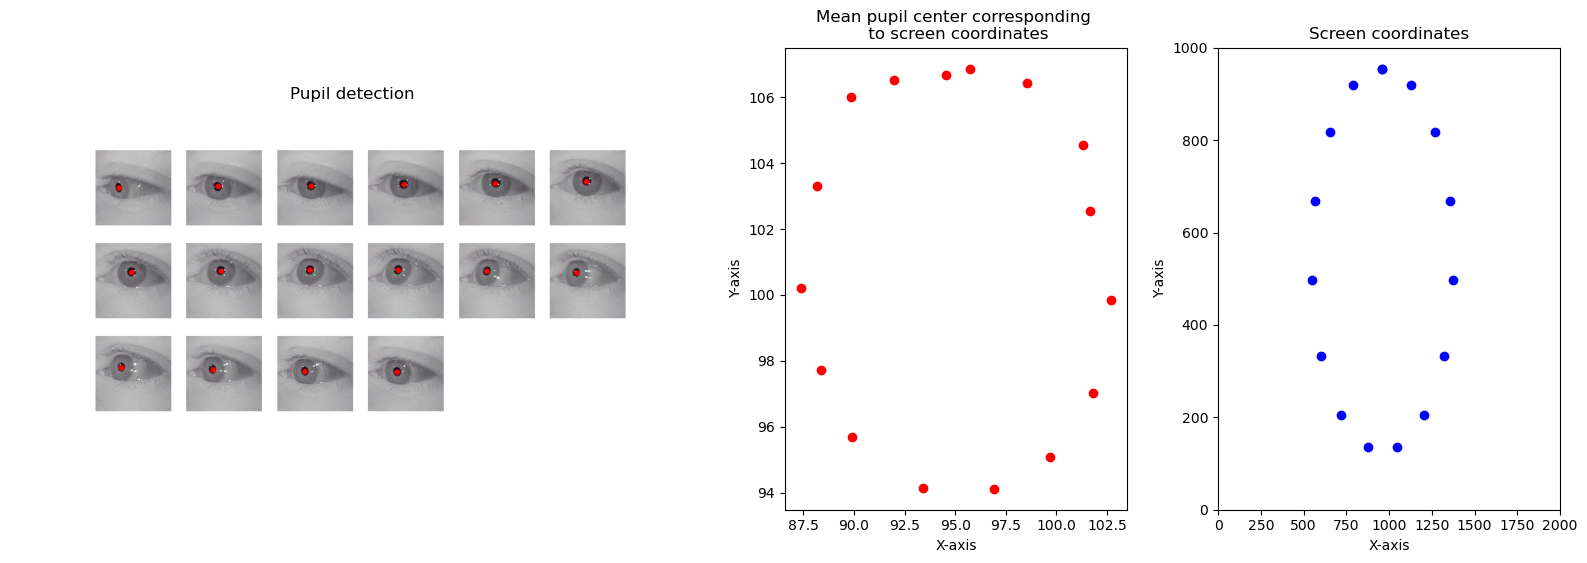

In [3]:
dataset = D[1] #change this index to show the different sessions

grid = iml_util.create_image_grid_viz(dataset)
iml_util.image_and_scatter(grid, dataset)

## Data Collection
In the folder `data`
 on OneDrive, you will find a datafolder `test_subject_1`
 containing a similar trial as you collected during data collection. 
In the following steps, you will be using the data set of `test_subject_1`
 as well as the data that you collected.

**Info**
A common challenge in machine learning is the presence of noise, which can corrupt data and impact the reliability of feature extraction. This issue is also relevant to the data collected for this assignment. If you encounter unreliable feature extraction, it is recommended to use the dataset from `test_subject_1`
.


---
**Task 3 (easy): Setup💡**
1. Describe the setup of the data collection was performed. Reflect on any pitfalls in the setup that may contribute to noisy data. What are the challenges of having multiple test subjects?


---

### Answer: 
There were issues with aligning the computer screen with the level of the eyes of the test subject (Mads). The setup was a little unstable, because we had to place the computer on top of books so that the subject would be able to see the patterns while the camera was also close to their eyes. 

## Data preperation

---
**Task 4 (easy): Frame extraction👩‍💻**
1. Download the folder `test_subject_1`
 from the `Data`
folder on Onedrive, and paste it in the folder `sessions`
 in exercises week 2, so it adhere to the structure visualized in the Data collection
.

2. Inspect the cell below as it contains the global variables for which test subject, trial and pattern used.



---

In [4]:
# DET HER SKAL KUN GØRES FOR TEST_SUBJECT_1
# Med Mads' data har vi allerede alle billed-frames
# Jeg har kun gjort det for test_subject_1 med Ellipse-mønstret

# Extract frames from the video
folder_name = 'test_subject_1'
pattern = 'ellipse'
#trial = '20250901_T0'
video_folder =f"../W02/sessions/{folder_name}/{pattern}.mp4"

frames_directory = f"../W02/sessions/{folder_name}/{pattern}/frames"
#output_directory = f"data/output/{folder_name}/{pattern}"

if not os.path.isdir(frames_directory):
    os.makedirs(frames_directory, exist_ok=True)
    iml_util.extract_frames(video_folder, frames_directory)

## Pupil center coordinate extraction
The next step is to preprocess the frames. The following cell contains the function, `pupil_detection`
, to detect pupils in images.

**Info**
You are not expected to understand the implementation in details. 

While there are multiple approaches to pupil detection, Carl Coder has made a pupil detection method using relatively simple means, designed to be transparent and intuitive to follow. As you will experience the method is not the most efficient or precise, and requires individual adjustments for each dataset.
The data preprocessing contains the following steps:
<div style="float: none; width: 100%; justify-content: start" class="block is-clearfix">

<div style="float: right; width: 35%; justify-content: start" class="block is-clearfix">

<div class="has-text-centered">
<figure class="image is-inline-block" id="pupil_detection">

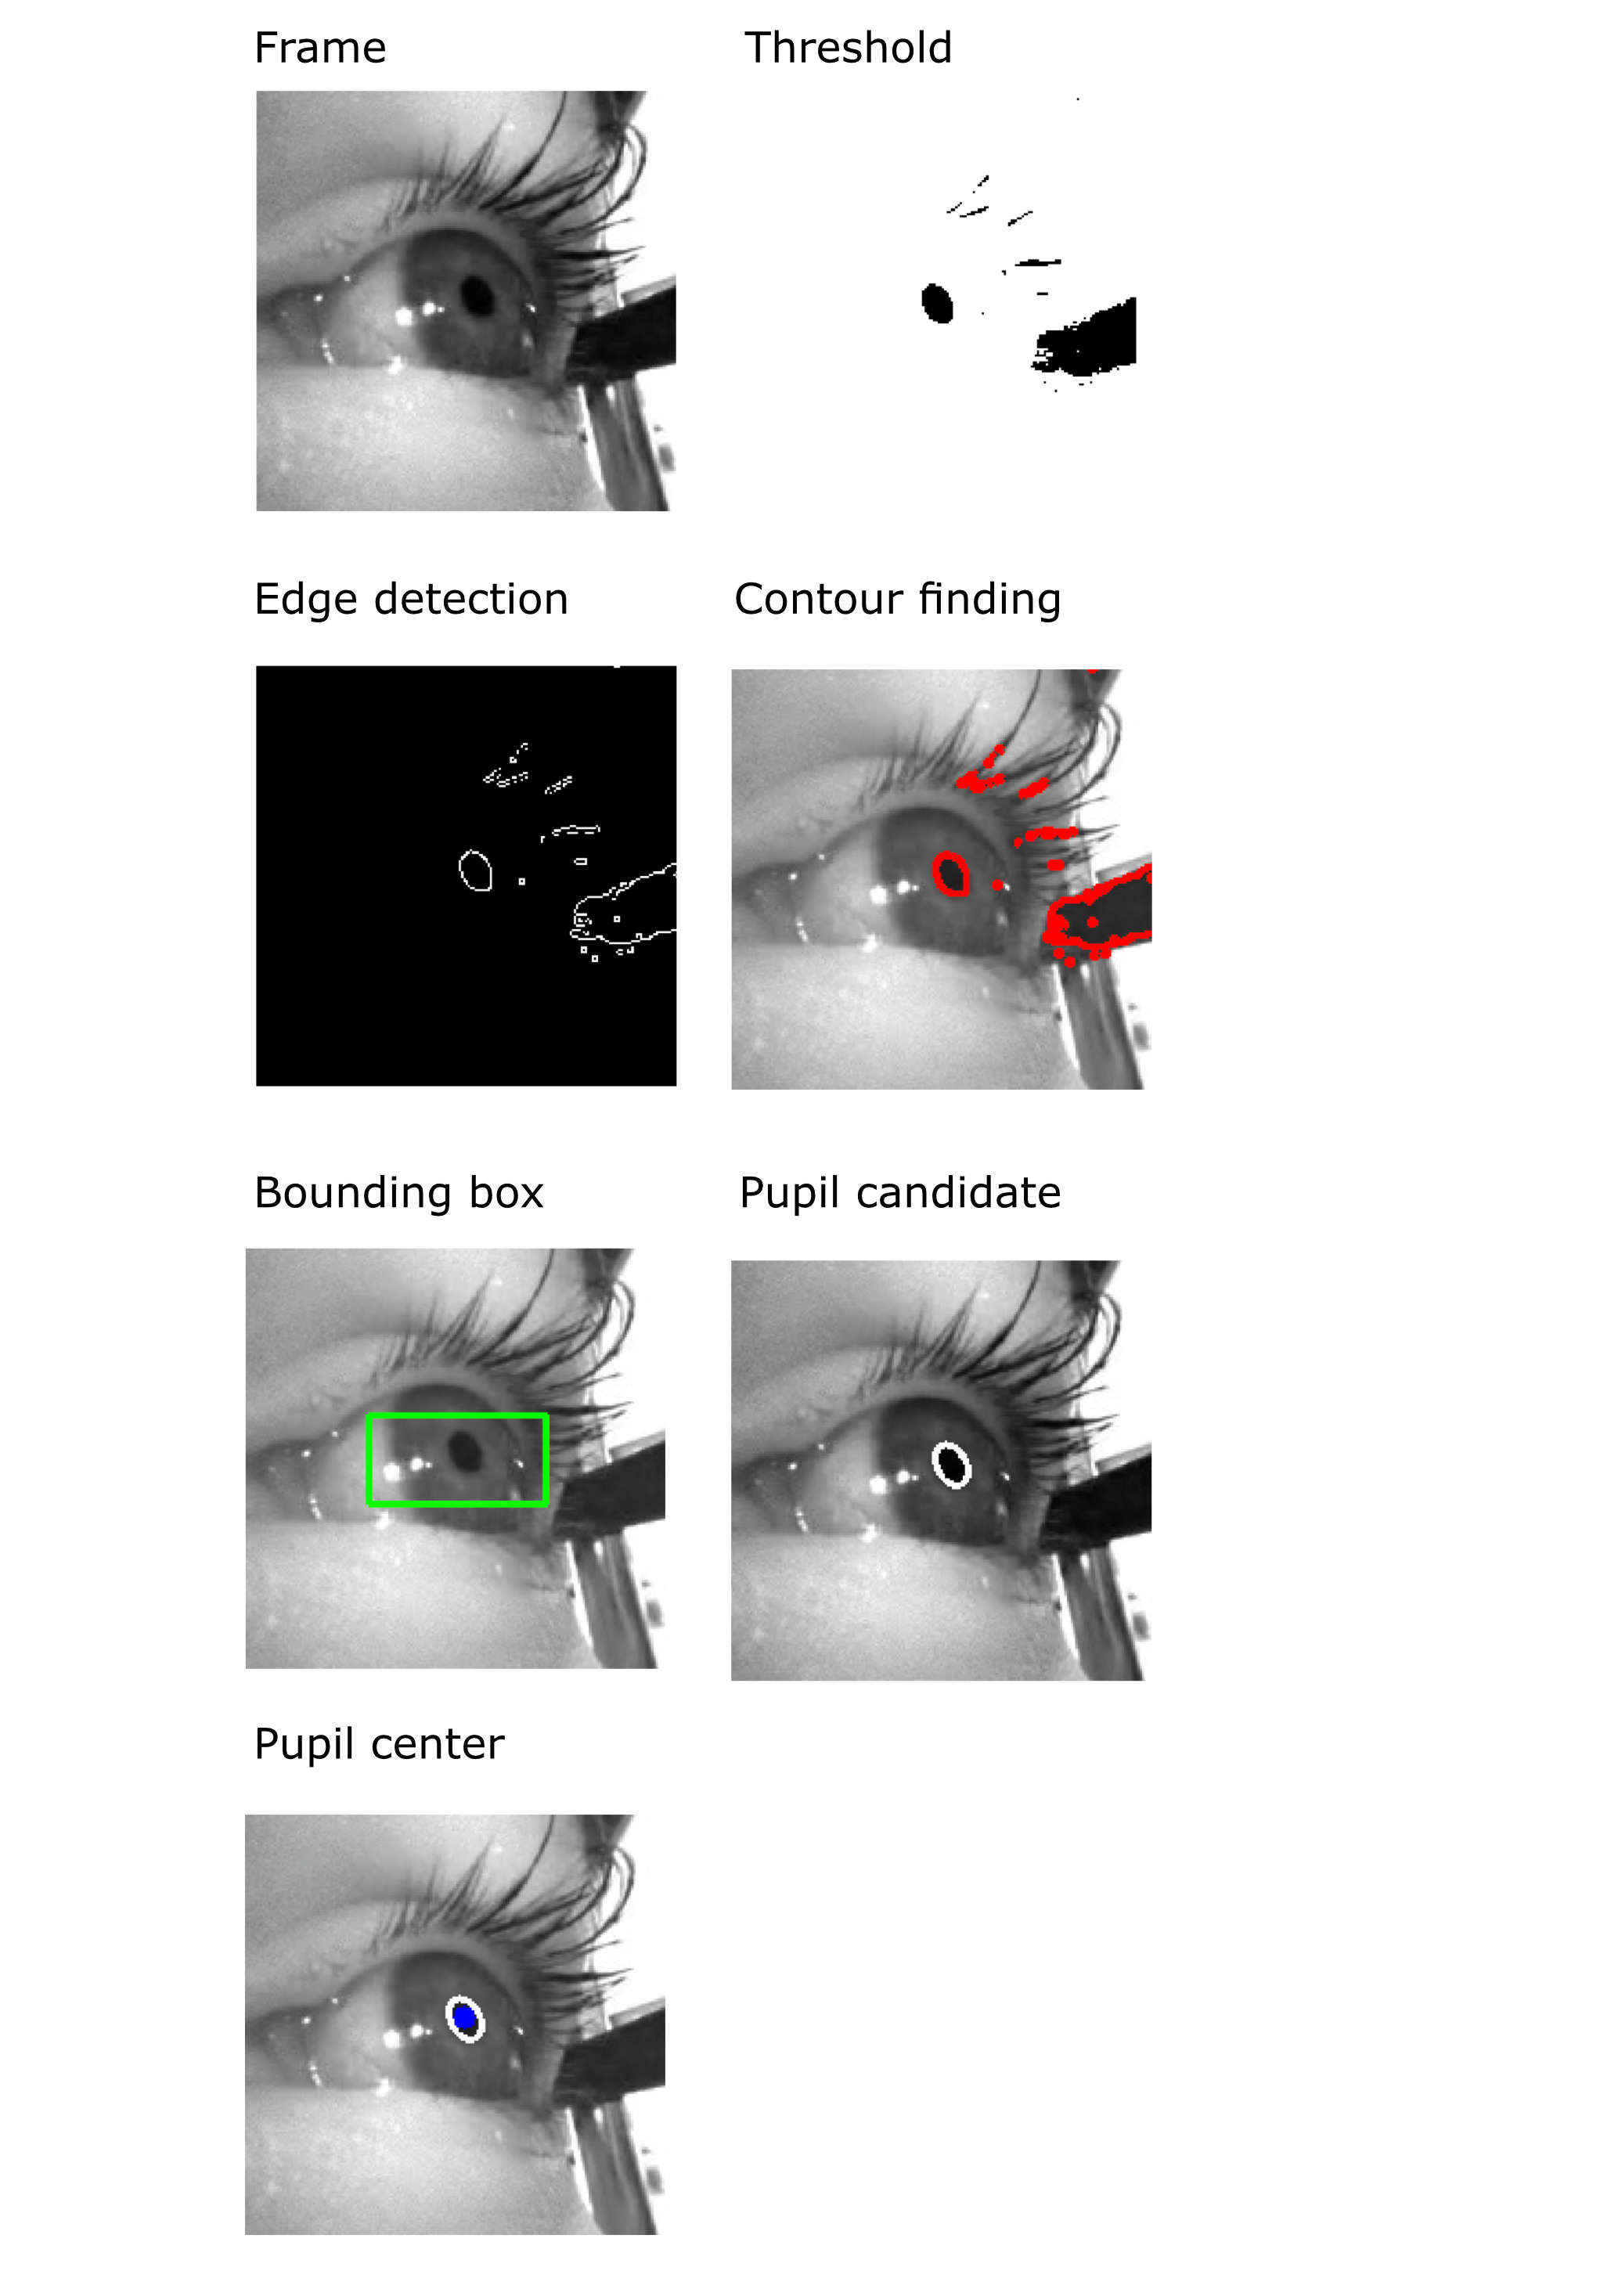

<figcaption class="figure-caption has-text-right">Figure 1: Visualization of the processing steps of finding the pupil center coordinate
</figcaption>
</figure>
</div>


</div>

<div style="float: left; width: 65%; justify-content: start" class="block is-clearfix">

- Threshold value
    - Thresholding the image to highlight potential pupil regions according to intensity


- Edge Detection
    - Detect edges in the thresholded image using the Canny edge detector.


- Contour Detection
    - Find contours within the edge-detected image.


- Ellipse Fitting
    - Fit ellipses to the detected contours that meet specific criteria (e.g., aspect ratio).


- Pupil Center Detection
    - Identify the most likely pupil center based on ellipse fitting within a defined bounding box.





</div>



</div>

For the best result you have to adapt the inputs to the method in accordence to each dataset. These values include _threshold_value_, _x_top_, _y_top_, _x_bottom_ and _y_bottom_. The _x_margin_ and _y_margin_ define a bounding box within pupil candidates are searched. This method is effective as the camera and head has been fixed throughout the data collection session. See figure [Figure 1](#pupil_detection) for the effect each of them apply. 


In [5]:
def pupil_detection(img, threshold_value, debug, x_top, y_top, x_bot, y_bot, max_axis_ratio=2):
    """
    Returns (x, y) in original image coordinates, or None.
    Skips frames if no fitted ellipse passes axis-size and axis-ratio checks.
    """

    cv = iml_util.cv

    # --- 0) Clamp + expand box, then crop ---
    x1, y1 = x_top, y_top
    x2, y2 = x_bot, y_bot


    roi = img[y1:y2, x1:x2].copy()
    roi_color = cv.cvtColor(roi, cv.COLOR_GRAY2BGR)

    if debug:
        dbg_full = cv.cvtColor(img.copy(), cv.COLOR_GRAY2BGR)
        cv.rectangle(dbg_full, (x1, y1), (x2, y2), (0, 255, 0), 2)
        iml_util.show_image('Bounding Box', dbg_full)
        iml_util.show_image('ROI (cropped)', roi)

    # --- 1) Threshold -> 2) Edges -> 3) Contours ---
    _, thresh = cv.threshold(roi, threshold_value, 255, cv.THRESH_BINARY)
    edges = cv.Canny(thresh, 100, 200)
    contours, _ = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    if debug:
        roi_cnt = roi_color.copy()
        cv.drawContours(roi_cnt, contours, -1, (255, 0, 0), 1)
        iml_util.show_image('ROI Contours', roi_cnt)
        iml_util.show_image('ROI Threshold', thresh)
        iml_util.show_image('ROI Edges', edges)

    # --- 4) Evaluate contours (largest first) until one is valid ---
    valid = None
    for c in sorted(contours, key=len, reverse=True):
        if len(c) < 50:
            continue
        ellipse = cv.fitEllipse(c)  # ((cx,cy),(MA,ma), angle)
        (cx, cy), (a1, a2), ang = ellipse
        major, minor = (max(a1, a2), max(1e-6, min(a1, a2)))
        ratio = major / minor

        if debug:
            print(f"[CAND] pts={len(c)} minor={minor:.2f} major={major:.2f} ratio={ratio:.2f}")

        if ratio > max_axis_ratio:
            continue

        valid = (ellipse, (cx, cy), major, minor, ratio)
        break  # choose first valid candidate

    if valid is None:
        if debug:
            print("[SKIP] No contour passed size/ratio checks.")
        return None

    ellipse, (cx, cy), major, minor, ratio = valid
    center = (cx + x1, cy + y1)

    if debug:
        # ROI view with chosen ellipse and overlays
        roi_draw = roi_color.copy()
        cv.ellipse(roi_draw, ellipse, (255, 255, 255), 2)
        cv.circle(roi_draw, (int(cx), int(cy)), 4, (0, 0, 255), -1)
        iml_util.show_image('ROI: Chosen ellipse', roi_draw)

        # Full-image view with found pupil center
        full_draw = cv.cvtColor(img.copy(), cv.COLOR_GRAY2BGR)
        cv.circle(full_draw, (int(center[0]), int(center[1])), 5, (0, 0, 255), -1)
        iml_util.show_image('Full image: Pupil center', full_draw)

    return center if center != (0, 0) else None

The cell below contains the main function for extacting the pupil features and the parameters to extract them. Pay attention to the `debug`
 option which will help you visualize the effect of each step and identify how to adjust the parameters.

---
**Task 5 (easy): Pupil detection👩‍💻**
_Your task is to experiment with the parameters to optimize pupil detection for your specific dataset. While it is not expected that you elaborate on the code, you are encouraged to examine it. A debug feature is provided in the parameter, which will help visualize each step in accordance to the values chosen._
1. Examine the code and familiarise yourself with the location of the parameters for adjustment.
2. Adjust the `frame_directory`
 variable to set the target frame folder for pupil center detection. 
3. Run the cell below and inspect the output in the visualized grid as well as the number of reported centers found compared to amount of images. 


**Info**
For successful feature extraction from frames, it is essential to visually recognize patterns in the pupil data plot. The number of frames processed does not determine extraction success; rather, the critical factor is the accurate mapping of pupil coordinates to corresponding screen coordinates, ensuring a pupil coordinate for each screen point.


**Important**
Note that function generates a `.csv`
 file with the pupil coordinates and the corresponding frame. The file is saved to the same `frame_directory`
 in which the frames processed are saved.

4. Run the cell below and toggle `debug = True`
 for visualization of the process.
5. Experiment with the different parameter settings to obtain the best pupil center detection possible for the given dataset. 
6. Once the parameter setting is optimized, you have to run the code for each pattern, but you are only required data for one eye. Choose the side that performs best.


---Please note that the default values are tailored to the dataset of `test_person_1`
.


Debug (279.9557456970215, 298.5803508758545)
Debug (280.89108657836914, 297.85732078552246)
Debug None
Debug (280.7568359375, 297.0370903015137)
Debug (281.0700798034668, 296.5553436279297)
Debug (280.9815368652344, 296.6107234954834)
Debug (281.0566749572754, 296.8266143798828)
Debug (280.52090072631836, 296.9581298828125)
Debug (281.3284339904785, 296.4319038391113)
Debug (280.8737258911133, 296.95474433898926)
Debug (281.2450065612793, 297.00107192993164)
Debug (281.41994857788086, 296.9010581970215)
Debug (281.10470962524414, 296.90161323547363)
Debug (281.88024520874023, 297.2159767150879)
Debug (281.17045974731445, 296.80421447753906)
Debug (281.18055725097656, 296.897403717041)
Debug (281.1795883178711, 296.62817192077637)
Debug (280.7821502685547, 296.68749809265137)
Debug (281.11288833618164, 296.9845905303955)
Debug (281.23925018310547, 296.9844093322754)
Debug (281.2436294555664, 296.6197204589844)
Debug (281.0975646972656, 296.8423480987549)
Debug (281.65501403808594, 297.0

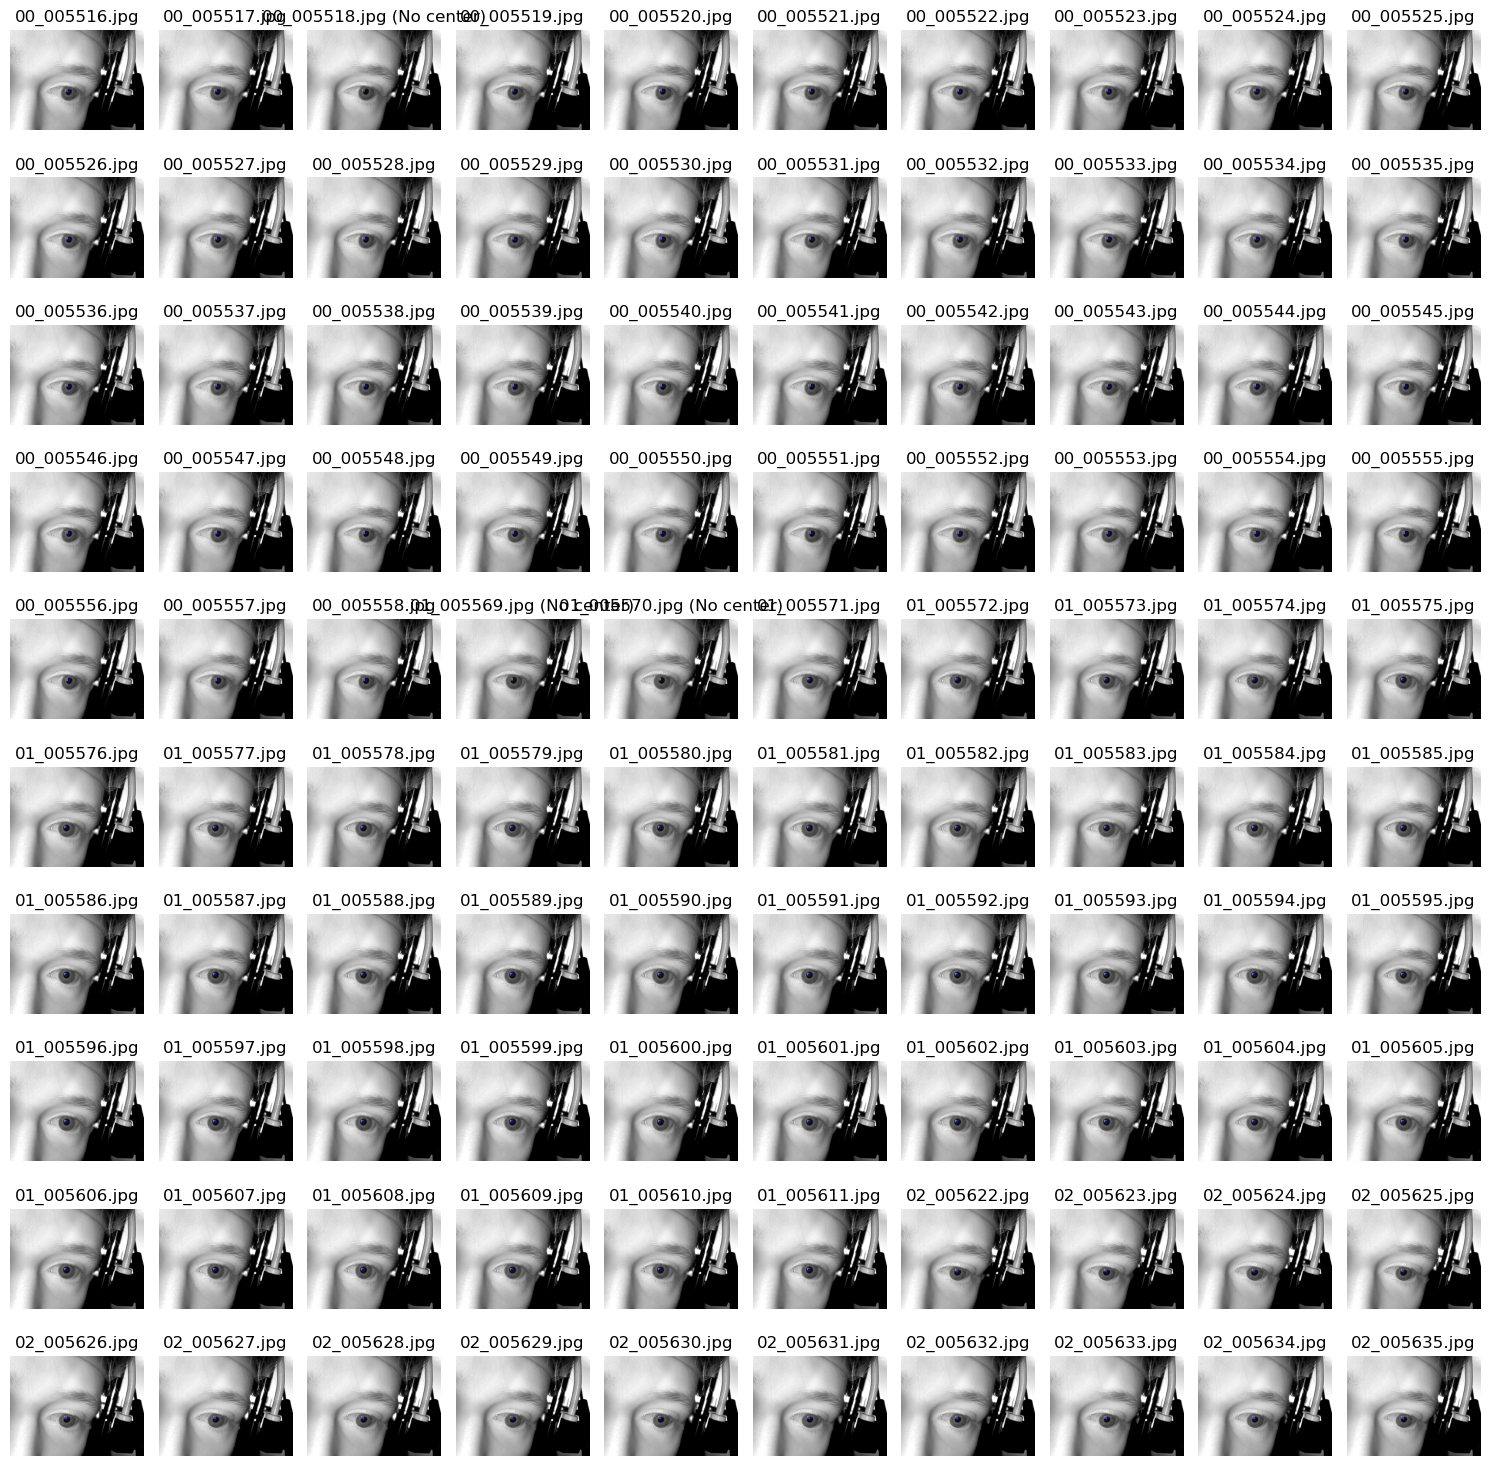

Total frames processed: 216
Number of detected centers: 167
Pupil coordinates saved to ../W02/sessions/mads/20250901_T0/random/frames/pupil_coordinates.csv


In [6]:
# Main function to process the video and detect centroids
def process_frames(output_directory, frames_folder, threshold_value, debug, x_top, y_top, x_bottom, y_bottom):
    """
    Detect pupil centers, and create image grids.

    Parameters:
        output_directory (str): The directory where extracted frames and output data will be saved.
        threshold_value (int): The threshold value for binarizing images during pupil detection.
        side (str): Indicates which side of the image to process ('left' or 'right'). Default is 'left'.
        debug (bool): If True, debug information and images will be displayed. Default is False.
        x_margin (int): The horizontal margin for cropping the eye region. Default is 40.
        y_margin (int): The vertical margin for cropping the eye region. Default is 20.

    Returns:
        None
    """
    
    # Load the extracted eye images
    eye_images = iml_util.load_images_from_folder(frames_folder)
    
    # Detect centroids in the images and store results in a DataFrame
    centers = []
    data = []
    valid_images = []  # To store images where centers are found
    valid_centers = []  # To store corresponding centers
    invalid_images = []  # To store images where centers are not found

    for image_file, img in eye_images:
        #left, right = iml_util.split_img(img)
        img = iml_util.split_img(img)

        center = pupil_detection(img, threshold_value, debug, x_top, y_top, x_bottom, y_bottom)
            
        if center:
            centers.append(center)
            valid_images.append((image_file, img))  # Store valid images
            valid_centers.append(center)  # Store corresponding centers
            data.append({"image": image_file, "px": center[0], "py": center[1]})
        else:
            centers.append(None)  # Ensure centers list is the same length as images
            invalid_images.append((image_file, img))  # Store invalid images
    
    # Create a pandas DataFrame
    df = iml_util.pd.DataFrame(data)
    df.to_csv(iml_util.os.path.join(output_directory, "pupil_coordinates.csv"), index=False)
    
    # Generate a 10x10 grid of images with pupil centers drawn
    iml_util.create_image_grid(eye_images, centers, output_directory, grid_name='pupil_centers_grid')
    
    # the following line displays the first 100 images. Uncomment to display images 0 to 100. Change the interval to show desired images.
    #iml_util.create_image_grid(eye_images[0:100], centers, output_directory, grid_name='pupil_centers_grid') 

    if debug:
        # DEBUG: Generate the grid of images where centers were not found, limited to 10x10
        iml_util.create_image_grid(invalid_images, [None]*len(invalid_images), output_directory,grid_name='invalid_pupil_centers_grid', max_images=100)
    
    # Print results
    print(f"Total frames processed: {len(eye_images)}")
    print(f"Number of detected centers: {len([c for c in centers if c is not None])}")
    print(f"Pupil coordinates saved to {iml_util.os.path.join(output_directory, 'pupil_coordinates.csv')}")

# Experiment with parameter values
# Herunder har jeg ladet alle values stå som jeg har brugt til de forskellige mønstre, sådan så I selv kan teste det hvis I vil
# I må også gerne prøve at ændre på værdierne hvis i tror I kan få koden til at detecte endnu flere pupils på Mads' data
# Men pls ik slet værdierne, bare udkommenter dem <3 det tog nemlig lidt tid at finde de rigtige som giver et ok højt antal detected pupils
''' Values for test_subject_1 ellipse left eye
threshold_value = 55
x_top = 70
y_top = 95
x_bottom = 150
y_bottom = 135'''

''' Values for Mads circle: 331 out of 429 pupils detected
threshold_value = 55
x_top = 230
y_top = 280
x_bottom = 330
y_bottom = 330'''

''' Values for Mads grid: 350 out of 386 pupils detected
threshold_value = 55
x_top = 230
y_top = 260
x_bottom = 330
y_bottom = 330'''

''' Values for Mads line: 341 out of 429 pupils detected
threshold_value = 55
x_top = 230
y_top = 280
x_bottom = 330
y_bottom = 330'''

#Values for Mads random: 167 out of 215 pupils detected
threshold_value = 55
x_top = 230
y_top = 280
x_bottom = 330
y_bottom = 330

# Sæt den her til True for at se step-by-step hvordan den bruger x og y til at lave en bounding box og udfra det finde pupilen. 
debug = False  # Set to True to see the debugging steps

# Ret i det her frames-directory for at prøve det af for forskellige mønstre 
frames_directory = f"../W02/sessions/mads/20250901_T0/random/frames"
process_frames(frames_directory,frames_directory, threshold_value, debug, x_top, y_top, x_bottom, y_bottom)


---
**Task 6 (easy): Pupil detection💡**
1. Reflect on the difficulties you experience, in terms of correctly detecting the pupil center.


---

### Answer: 
It requires some trial and error in order to get the bounding box right. We also experienced difficulties when trying to find the pupil of the eye on the right (for test subject 1), so we decided to do it with the eye on the left instead. The threshold value also required some adjustment in order to make the contrast as clear as possible. We also noticed that even though some specific values for the x, y and threshold can detect pupils in some of the images, the same settings might not necessarily work for other images in the same dataset. 

## Plotting
The cell below generates a scatter plot of the extracted pupil centers. At this stage of the exercise, you are only to manually estimate the pupil centers corresponding to each screen coordinate.
Later in the course, you will be introduced to more advanced, data-driven methodologies for calculating the pupil centers.
Feel free to go beyond the current requirements and explore the development of a simple algorithm to automate the calculation of the mean pupil center. If doing so, keep in mind that it can become a time sink, and remember it is neither required nor expected.

---
**Task 7 (easy): Visualize pupil centers👩‍💻**
1. Run the cell below to visualize the pupil coordinates. 

**Info**
Use the variables `x_min`
, `x_max`
, `y_min`
, `y_max`
 to adjust the view of the scatterplot.




---

/Users/albert/pythonProjs/iml_project_2025/W06/../W02/sessions/mads/20250901_T0/grid/frames/pupil_coordinates.csv


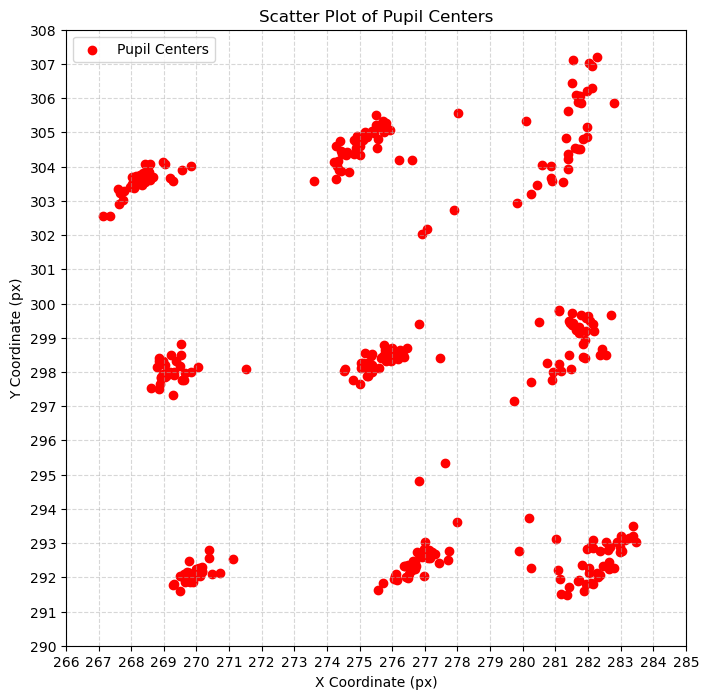

In [7]:
# JEG HAR TILFØJET NOGET KODE I IML_UTIL SOM TILFØJER EKSTRA GRID LINJER NÅR MAN KØRER VISUALISERINGEN SÅ PLOTTET ER NEMMERE AT AFLÆSE
# BARE UDKOMMENTER DEM HVIS DE IKKE SKAL BRUGES
# I LINJE 423-425 I IML_UTIL

import matplotlib.pyplot as plt
import pandas as pd
#frames_directory = f"../W02/sessions/test_subject_1/ellipse/frames"
#frames_directory = f"../W02/sessions/mads/20250901_T0/circle/frames"
frames_directory = f"../W02/sessions/mads/20250901_T0/grid/frames"
#frames_directory = f"../W02/sessions/mads/20250901_T0/line/frames"
#frames_directory = f"../W02/sessions/mads/20250901_T0/random/frames"

csv_file = f"{frames_directory}/pupil_coordinates.csv"
''' Test_subject_1 ellipse:
x_min = 50
x_max = 200
y_min = 50
y_max = 200'''

'''# Mads circle:
x_min = 266
x_max = 285 #Sæt til 310 hvis man vil have outliers med
y_min = 296
y_max = 307'''

# Mads grid:
x_min = 266
x_max = 285
y_min = 290
y_max = 308

'''# Mads line:
x_min = 268
x_max = 286 #Sæt til 320 hvis man vil have outliers med
y_min = 299
y_max = 305'''

'''# Mads random:
# Det her plot er mega svært at aflæse efter jeg har tilføjet de ekstra grid-linjer, fordi punkterne ligger så random fordelt
# Så hvis man vil se det bedre, så enten gør x_max mindre (dvs man fjerner nogle punkter som ligger meget langt til højre ift. resten)
# og ellers så kan man udkommentere linje 423-425 i iml_util så der ikke vises så mange tal på x-aksen og grid lines i plottet. 
x_min = 266
x_max = 320
y_min = 293
y_max = 318'''

iml_util.visualize_pupil_centers(csv_file, pattern, x_min, x_max, y_min, y_max)


---
**Task 8 (easy): Preprocess your data👩‍💻**
1. Rerun the entire exercise using your own data collected.

### DONE!
---
---
**Task 9 (easy): Determine pupil centers👩‍💻**
1. Inspect the scatter plot for your own data and determine the coordinates for the mean pupil center corresponding to each screen coordinate. Fill in the missing values for the keys in the dictionary `D`
 below with pupil coordinates for your own dataset. You should pay attention to the `S`
 dictionary representing the screen coordinates. The order of the pupil coordinates has to match the order in the `S`
 dictionary.


---

In [8]:
S = {'grid':      np.array([[100, 100], [960, 100], [1820, 100], [100, 540], [960, 540], [1820, 540], [100, 980],  [960, 980],   [1820, 980]]),
     'circle':    np.array([[1820.0, 540.0],  [1655.7546151624547, 746.9004088069505], [1225.7546151624547, 874.7718937358941], [694.2453848375453, 874.7718937358941],  [264.2453848375453, 746.9004088069506], [100.0, 540.0],[264.2453848375452, 333.0995911930495],[694.2453848375451, 205.22810626410597],[1225.7546151624547, 205.22810626410592],[1655.7546151624547, 333.0995911930494]]),
     'line':      np.array([[100.0, 540.0], [291.1111111111111, 540.0], [482.22222222222223, 540.0], [673.3333333333334, 540.0], [864.4444444444445, 540.0], [1055.5555555555557, 540.0], [1246.6666666666667, 540.0], [1437.7777777777778, 540.0], [1628.888888888889, 540.0], [1820.0, 540.0]]),
     'random': np.array([[647, 174],[1642, 64],[1264, 967],[1034, 671],[269, 790]])
}

# Der står længere oppe at vi lige nu ikke behøver lave nogen funktiner der kan udregne mean, så vi skal bare estimere ved at kigge på 
# plottet længere oppe for hvert mønster og så komme med et kvalificeret bud - jeg kiggede på de forskellige "clusters" af punkter
# for Grid-mønstret og så fandt jeg cirka midten af de punkter. 
# Man skal lige holde øje med at man tager punkterne i den rigtige rækkefølge, dvs. for grid startede jeg med at finde det "cluster" af 
# pupils som cirka svarede til 100,100-punktet (selvom vores koordinater er nogle højere tal, men mønsteret er jo det samme), og så fandt 
# jeg det "cluster" af pupils som cirka svarede til 960,100-punktet osv.  

# Jeg har ikke kigget tallene ordentligt igennem for test_subject_1, de stod her i forvejen og de ser helt forkerte ud 
# men magtede ikke lige at tjekke dem igennem, så har kun skrevet tal ind for Mads for Grid-mønstret. 

D = {'test_subject_1': {'grid':    np.array([[321.48334503, 214.03111649], [301.28318405, 214.14067078], [284.32447624, 216.49548531], [318.11744308, 224.92201996], [299.27832413, 225.69578362], [285.48396683, 226.32367325], [319.07626343, 234.10630798], [300.15304565, 234.84591675], [284.91255951, 235.34350204]]),
                        'circle':  np.array([[286.94417953, 226.32931519], [290.72671509, 233.28370285], [295.67311859, 235.40619278], [307.14255524, 234.44820786], [316.449646 ,  229.99293137], [319.94413757, 224.51420212], [317.1031189 , 218.76191711], [308.94825363, 215.3417778 ], [299.45336914, 216.17896271], [292.07669258, 221.67927742]]),
                        'line':    np.array([[329.38616943 ,225.68050766], [324.65599823 ,226.78267288], [319.59163666, 227.57630157],[313.18978119, 226.31406784], [307.61574173, 227.28095627], [303.15340614, 226.82514381],[299.89761734, 226.52946854],[297.20285988, 228.45379066], [295.68857956, 229.4874382 ],[292.63830566, 230.54410744]]), 
                        'random':  np.array([[314.99221802, 216.1681366 ], [283.88474083, 216.38289452], [298.76196671, 242.43567276], [302.86785889, 233.71765518], [330.42033005, 236.04451752]])},
      'mads': { 'grid': np.array([[268.5, 303.5],[275, 305], [281.5, 304.5], [269.5, 298], [275.5, 298.5], [281.5, 299], [270, 292], [276.5, 292.5], [282.5, 292.5]]),
               'circle': np.array([[283, 300.5], [280, 298.5], [276, 298], [273.5, 298], [272.5, 299.5], [270, 301], [273, 303.5], [277.5, 305], [281.5, 304.5], [282.5, 302.5]]), 
               'line': np.array([[269.5, 301.5], [271.5, 302], [273.5, 302.5], [274.5, 302.5], [276, 302], [278, 302.5], [279.8, 302.5], [281, 302.5], [283, 303], [285, 304]]), 
               'random': np.array([[271.5, 306], [283, 306], [281, 297], [275.5, 302.5], [269.5, 294.2]])} 
                     
}

In [9]:
# Har ikke kørt det her kode endnu fordi jeg ikke blev færdig med ovenstående
#test_subject = 'test_subject_1' # change the variable 'test_subject* in accordance to the naming of the folder containing your data and run
# De her paths skal laves om for at få det til at virke
#folder_name = 
iml_util.save_coordinates_to_csv(S, f'../W02/sessions/test_subject_1/20250901_T0', 'screen')
iml_util.save_coordinates_to_csv(D['test_subject_1'], f'../W02/sessions/test_subject_1/20250901_T0', 'mean_pupil')

Saved grid coordinates to ../W02/sessions/test_subject_1/20250901_T0/grid/screen_coordinates.csv
Saved circle coordinates to ../W02/sessions/test_subject_1/20250901_T0/circle/screen_coordinates.csv
Saved line coordinates to ../W02/sessions/test_subject_1/20250901_T0/line/screen_coordinates.csv
Saved random coordinates to ../W02/sessions/test_subject_1/20250901_T0/random/screen_coordinates.csv
Saved grid coordinates to ../W02/sessions/test_subject_1/20250901_T0/grid/mean_pupil_coordinates.csv
Saved circle coordinates to ../W02/sessions/test_subject_1/20250901_T0/circle/mean_pupil_coordinates.csv
Saved line coordinates to ../W02/sessions/test_subject_1/20250901_T0/line/mean_pupil_coordinates.csv
Saved random coordinates to ../W02/sessions/test_subject_1/20250901_T0/random/mean_pupil_coordinates.csv



---
**Task 10 (easy): Pupil detection💡**
1. Use the reflections from [Task 3](#Experiment-setup) and [Task 6](#Pupil_detection11) to elaborate on the results displayed in the scatter plot. For example:    - Are the potential pitfalls you discussed in [Task 3](#Experiment-setup) influencing the result? If so, in which context does it become visible? 
    - How are the limitations in the pupil detection expressed in the final result of the pupil centers for each calibration point?
    - Additional observations?




---

#Write your reflections here...
1. One pitfall we discussed was the setup used to collect our dataset, which differed from how the other test subjects data had been gathered. Our collection is zoomed much further out from the eye, resulting in our data lacking details. 